*************************************************
# Energy Calibration
*************************************************

In [1]:
import cait as ai
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Rate and Stability Cuts

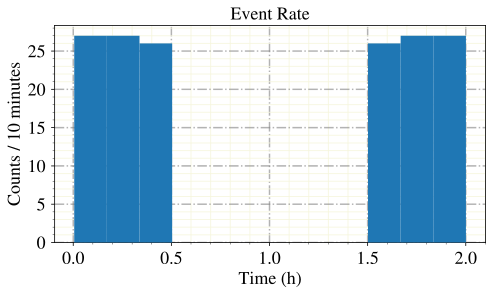

In [4]:
dh.show_values(group='events', key='hours', bins=12, 
               xlabel='Time (h)', ylabel='Counts / 10 minutes', title='Event Rate')

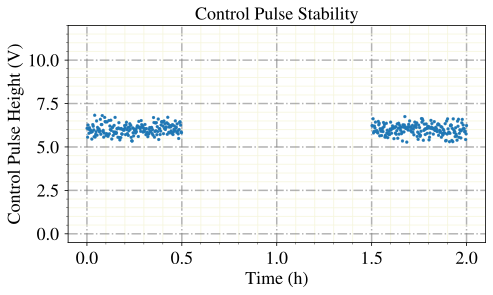

In [5]:
dh.show_scatter(groups=['controlpulses', 'controlpulses'],
                        keys=['hours', 'pulse_height'],
                        idx0s=[None, 0],
                        xlabel='Time (h)',
                        ylabel='Control Pulse Height (V)',
                        yran=(-0.5, 12),
                        title='Control Pulse Stability'
                        )

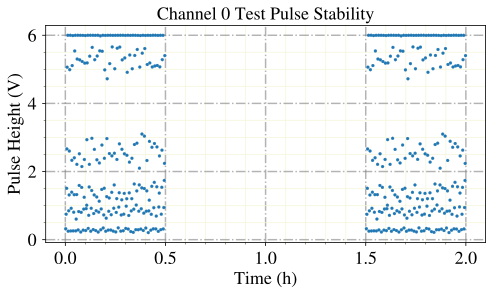

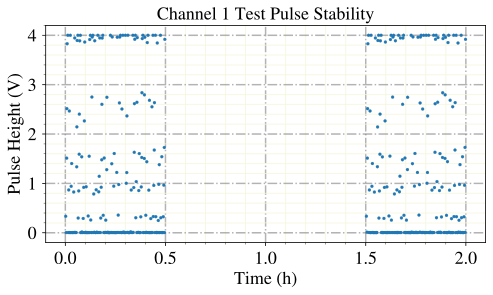

In [39]:
for c in [0,1]:
    dh.show_scatter(groups=['testpulses', 'testpulses'],
                    keys=['hours', 'mainpar'],
                    idx0s=[None, c],
                    idx2s=[None, 0],
                    xlabel='Time (h)',
                    ylabel='Pulse Height (V)',
                    marker='.',
                    title='Channel {} Test Pulse Stability'.format(c)
                    )

In [9]:
dh.calc_controlpulse_stability(channel=0, significance=3, lb=5, ub=7.5)

Do Testpulse Stability Cut
Control Pulse PH 6.009 +- 0.304, within 3 sigma: 100.000 %
Good Control Pulses: 400/400 (100.000%)
Good Events: 158/160 (98.750%)
Good Time: 0.994h/2.000h (49.708%)


In [8]:
dh.calc_rate_cut()

Do Rate Cut.
Rate: (13.250 +- 13.255)/10m
Good Rate per 10m (3 sigma): 0.000 - 53.014
Good Time: 2.000h/2.000h (100.000%)
Good Events: 159.000/160.000 (99.375%)


## Find CPE Factor

In [23]:
channels = [0, 1]

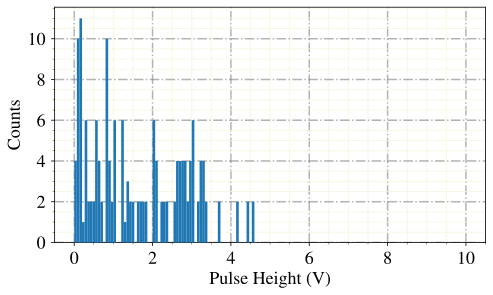

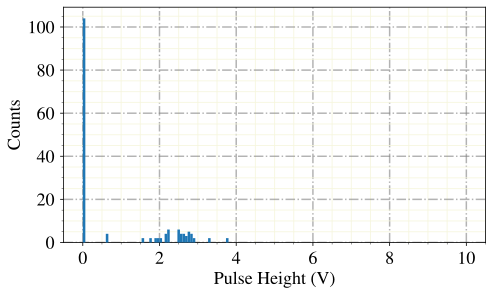

In [24]:
for c in channels:
    dh.show_values(group='events', key='mainpar', bins=150, idx0=c, idx2=0, range=(0, 10),
               xlabel='Pulse Height (V)', ylabel='Counts')

In [27]:
ph = dh.get('events','mainpar')[:, :, 0]
lb = [2.5, 2]
ub = [3.5, 3]
calibration_peak = []

for c in channels:
    peak_events = ai.cuts.LogicalCut(initial_condition=ph[c]>lb[c])
    peak_events.add_condition(ph[c]<ub[c])

    calibration_peak.append(np.mean(ph[c, peak_events.get_idx()]))
    print('Peak position with PH: ', calibration_peak[-1])

Peak position with PH:  2.952924888758432
Peak position with PH:  2.52170441955328


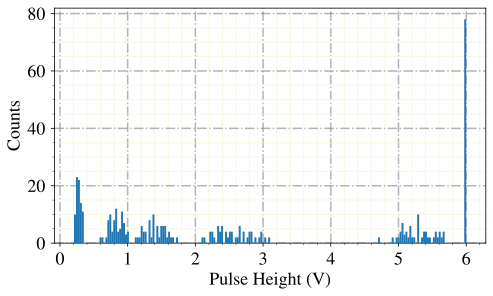

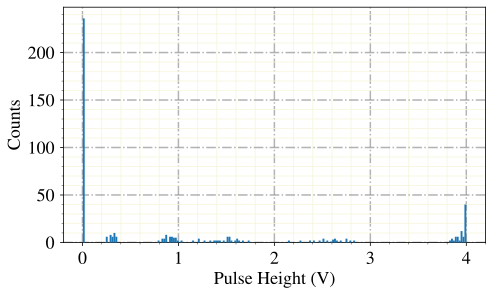

In [29]:
for c in channels:
    dh.show_values(group='testpulses', key='mainpar', bins=200, idx0=c, idx2=0,
                   xlabel='Pulse Height (V)', ylabel='Counts')

In [33]:
ph_tp = dh.get('testpulses','mainpar')[:, :, 0]
tpas = dh.get('testpulses','testpulseamplitude')
    
tpa_peaks = []
lower_bounds = [0.6, 1.1]
upper_bounds = [1.2, 1.8]
two_tpas = [0.3, 0.5]

for c in channels:
    two_peaks = []
    for i, val in enumerate(two_tpas):
        peak_events = ai.cuts.LogicalCut(initial_condition=ph_tp[c] > lower_bounds[i])
        peak_events.add_condition(ph_tp[c] < upper_bounds[i])
        peak_events.add_condition(np.isclose(tpas, val))
        two_peaks.append(np.mean(ph_tp[c, peak_events.get_idx()]))
        print('Channel {}: Peak position TPA {} from {} events, with PH: {}'.format(c, val, len(peak_events.get_idx()), two_peaks[-1]))
    tpa_peaks.append(two_peaks)

Channel 0: Peak position TPA 0.3 from 80 events, with PH: 0.8265990979224445
Channel 0: Peak position TPA 0.5 from 78 events, with PH: 1.410274501412343
Channel 1: Peak position TPA 0.3 from 44 events, with PH: 0.9101242339069192
Channel 1: Peak position TPA 0.5 from 46 events, with PH: 1.4705729939367458


In [34]:
energy_calibration_peak = 5.89  # iron line
cpe_factor = []

for c in channels:
    tpa_calibration_peak = two_tpas[0] + (calibration_peak[c] - tpa_peaks[c][0])*(two_tpas[1] - two_tpas[0])/(tpa_peaks[c][1] - tpa_peaks[c][0])
    print('Channel {}: The TPA corresponding to the calibration peak is {} V.'.format(c, tpa_calibration_peak))
    cpe_factor.append(energy_calibration_peak / tpa_calibration_peak)
    print('Channel {}: The CPE factor is then {} keV/V.'.format(c, cpe_factor[-1]))

Channel 0: The TPA corresponding to the calibration peak is 1.0285987307747797 V.
Channel 0: The CPE factor is then 5.726236892751586 keV/V.
Channel 1: The TPA corresponding to the calibration peak is 0.8751034886973768 V.
Channel 1: The CPE factor is then 6.730632520694756 keV/V.


## Energy Calibration

In [41]:
for c in channels:
    dh.calc_testpulse_stability(c, significance=1)

Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 478/478 (100.000%)
TPA 0.100 with PH 0.278 +- 0.037, within 1 sigma: 63.750 %
TPA 0.300 with PH 0.827 +- 0.097, within 1 sigma: 67.500 %
TPA 0.500 with PH 1.400 +- 0.167, within 1 sigma: 65.000 %
TPA 1.000 with PH 2.560 +- 0.263, within 1 sigma: 62.500 %
TPA 3.000 with PH 5.274 +- 0.231, within 1 sigma: 62.500 %
TPA 10.000 with PH 5.997 +- 0.003, within 1 sigma: 89.744 %
Good Testpulses: 327/478 (68.410%)
Good Events: 103/160 (64.375%)
Good Time: 1.673h/1.998h (83.695%)
Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 321/478 (67.155%)
TPA 0.100 with PH 0.217 +- 0.142, within 1 sigma: 69.231 %
TPA 0.300 with PH 0.692 +- 0.391, within 1 sigma: 75.862 %
TPA 0.500 with PH 1.188 +- 0.593, within 1 sigma: 80.702 %
TPA 1.000 with PH 1.925 +- 1.118, wi

Energy Calibration for Channel  0
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]


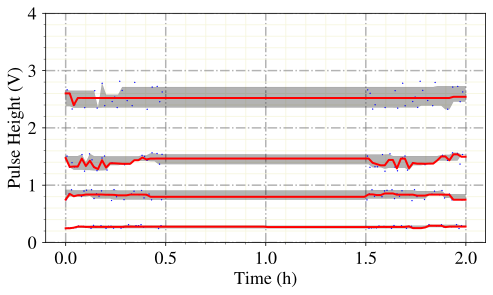

Plot Regression Polynomial at 0.999 hours.


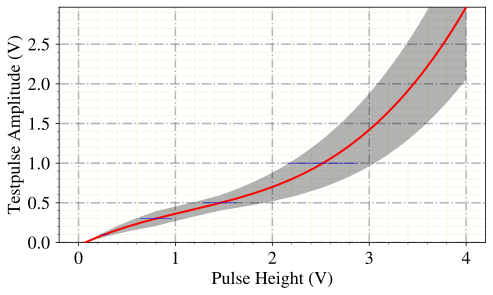

Calculating Recoil Energies: 0.0 %
Energy Calibration for Channel  1
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]


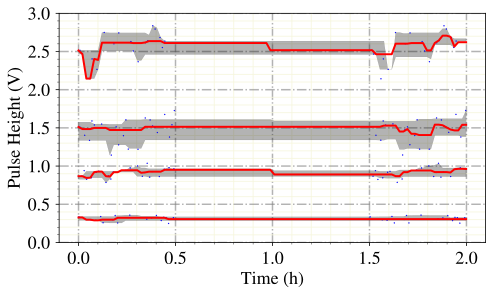

Plot Regression Polynomial at 0.999 hours.


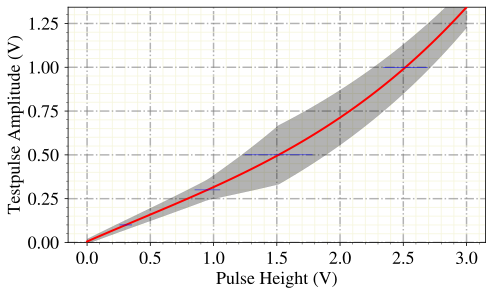

Calculating Recoil Energies: 0.0 %
Finished.


In [42]:
dh.calc_calibration(starts_saturation=[4,3],
                        cpe_factor=cpe_factor,
                        plot=True,
                        only_stable=True,
                        tree=True,
                        linear_with_uncertainty=False,
                        #cut_flag=cut_flag,
                        poly_order=3,
                        )